# MNIST Handwritten Digit Classifier

This project is closely related to another project of mine, "newsgroups-naive-bayes". Both .ipynb files are scratch-built implementations of the naive Bayes theorem, without any help from pre-built sklearn modules. Where the two differ is in what is being classified: text documents for the newsgroups repo (multinomial), and handwritten digits for this repo (gaussian). Images from the MNIST database are flattened into single dimension arrays and then fed through my Bayes classifier, spitting out predicted labels for each image. 

## Environment Setup

First, a little setup is required. Pre-split train / test labels and data are pulled from the URLs below, unpacked and reorganized for ease of use.

In [12]:
# download files, unpack, organize, and cleanup
from itertools import product
import glob, gzip, requests

!rm -rf w09q04

train_images_url = 'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz'
train_labels_url = 'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz'
test_images_url = 'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz'
test_labels_url = 'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'

for a, b in product(['train', 'test'], ['images', 'labels']):
    target = f'{a}_{b}_url'
    url = eval(target)
    fname = url[url.find('mnist/')+6:]
    r = requests.get(url)
    open(fname, 'wb').write(r.content)

!mkdir w09q04

file_list = glob.glob('*.gz')
for fname in file_list:
    f_in = gzip.open(fname, 'rb')
    content = f_in.read()
    f_out = open('./w09q04/'+fname[:-3].replace('s-idx', 's.idx'), 'wb')
    f_out.write(content)
    f_in.close()
    f_out.close()

!rm *.gz

## Useful Functions

A couple functions for use later in this notebook; the first two are tools to load data from the unzipped files and store them in arrays.

In [13]:
# image loader function
def load_images(filename):
    with open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset = 16)
    data = data.reshape(-1, 784)
    return data / np.float32(256)

In [14]:
# label loader function
import numpy as np

def load_labels(filename):
    with open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset = 8)
    return data

In [15]:
# loading images / labels
train_data = load_images('./w09q04/train-images.idx3-ubyte')
train_labels = load_labels('./w09q04/train-labels.idx1-ubyte')

test_data = load_images('./w09q04/t10k-images.idx3-ubyte')
test_labels = load_labels('./w09q04/t10k-labels.idx1-ubyte')

Next, a function to visualize digits via matplotlib. This makes for easy comparison of predictions with the actual digits later on. The function shows digits in a 28x28 matrix form, with grey-scale gradient contextualizing the color values in each pixel.

In [16]:
# image display
import matplotlib.pyplot as plt

def displaychar(image):
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.axis('off')
    plt.show()

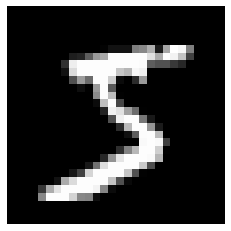

In [17]:
# displaying first data point
displaychar(train_data[0])

## Classifier Construction

The train dataset was shuffled and split again to form a validation set, for use later on. The naive Bayes theorem calls for two calculations, log label priors and log digit probability density functions. Priors were calculated before the model's creation, and PDFs calculated on the fly in the "digit_classifier" function.

In [18]:
# test train split
shuffler = np.arange(60000).reshape((60000, ))
np.random.shuffle(shuffler)
validation_data = train_data[shuffler][:10000]
validation_labels = train_labels[shuffler][:10000]
train_data = train_data[shuffler][10000:]
train_labels = train_labels[shuffler][10000:]
print(f'Shape of train set: {train_data.shape}\nShape of validation set: {validation_data.shape}')

Shape of train set: (50000, 784)
Shape of validation set: (10000, 784)


In [19]:
# log priors calculations
import pandas as pd

_, counts = np.unique(train_labels, return_counts = True)
log_priors = np.log(counts/counts.sum())
log_priors

array([-2.31182767, -2.18142997, -2.3181049 , -2.28023669, -2.33841955,
       -2.40705711, -2.30940832, -2.25646516, -2.32340023, -2.31486012])

In [20]:
# generating model and predictions
from scipy.stats import multivariate_normal as mvn

def digit_classifier(x, c = 0):
    '''
    Creates a multivariate Naive Bayes model to predict handwritten digits.

    Arguments:
        x {array, floats} -- Flattened array representing a single or collection of handwritten digits.
        c {float} -- Covariance smoothing coefficient used in model generation. Defaults to 0.

    Returns:
        predictions {array, integers} -- Predicted digit(s), size depends on number of rows in x.
        prob_bucket {array, floats} -- Log probabilities for digit(s) in x, size depends on number of rows in x.
    '''
    x = np.atleast_2d(x)
    mvn_bucket = []
    for i in range(10):
        filter = [a for a in range(train_labels.shape[0]) if train_labels[a] == i]
        mean = np.mean(train_data[filter], axis = 0)
        cov = np.cov(train_data[filter], rowvar = False) + (float(c) * np.eye(784))
        mvn_bucket.append(mvn(mean = mean, cov = cov, allow_singular = True))
    predictions = np.zeros((x.shape[0], ))
    prob_bucket = np.zeros((x.shape[0], 10))
    for i in range(x.shape[0]):
        log_pdfs = list(map(lambda obj: obj.logpdf(x[i]), mvn_bucket))
        prob_bucket[i] = log_pdfs + log_priors
        predictions[i] = np.argmax(log_pdfs + log_priors)
    return predictions, prob_bucket

With the classifer function out of the way, the last step is a bit of optimization for covariance smoothing. This step is a bit time consuming so the only c values explored below are those closest to the absolute minimum. The actual range tested was from .0001 to 10000 in semi-exponential steps.

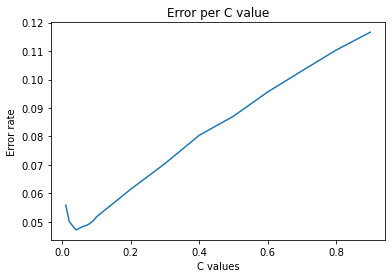

In [21]:
# optimizing c smoothing values
import matplotlib.pyplot as plt

cs = [i/100 for i in range(1, 10)]
cs.extend([i/10 for i in range(1, 10)])
errors = []
for c in cs:
    pred, _ = digit_classifier(validation_data, c)
    errors.append(np.where(validation_labels != pred, 1, 0).sum()/validation_labels.shape[0])
fig, ax = plt.subplots()
ax.plot(cs, errors)
ax.set(title = 'Error per C value', xlabel = 'C values', ylabel = 'Error rate')
plt.show()


In [22]:
# optimal c value
c_opt = cs[np.argmin(errors)]
print(f'Optimal C value: {c_opt}')

Optimal C value: 0.04


In [23]:
# predictions and error rate
pred, probs = digit_classifier(test_data, .06)
filter = [i for i in range(test_labels.shape[0]) if test_labels[i] != pred[i]]
print(f'Test error rate: {round(100*len(filter)/test_labels.shape[0], 2)}%')


Test error rate: 4.35%


At a c value of .04, error was minimized to 4.35%. With a bit more fine tuning I am sure this number could be dropped a bit more, but ~4% was good enough for the purposes of this repo. A quick cursory search through a series of search engine yielded accuracies as high as 99%, though mostly though the application of neural networks or other more complex algorithms.

Sample #1
Label: 5
Prediction: 2.0


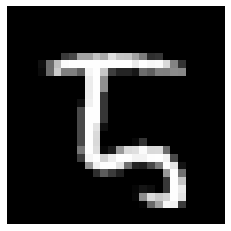

[ 99.16682133 -11.47522313 125.56124021 100.72773481  92.20765386
 124.37213553  63.55163704  85.97944139 111.40447978 103.7558046 ]
Sample #2
Label: 7
Prediction: 1.0


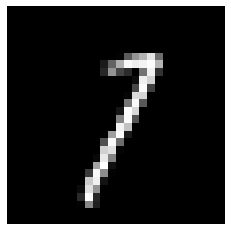

[182.52421213 280.61154625 219.88494068 206.86674596 238.57125118
 185.61601535 191.63817735 267.70621048 234.84495197 254.79710127]
Sample #3
Label: 7
Prediction: 9.0


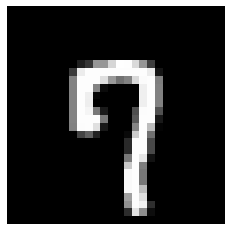

[149.22969792  60.59594867 154.28307808 170.9869067  217.98463337
 173.0673674   79.72882728 257.91372158 188.82584449 264.47134319]
Sample #4
Label: 7
Prediction: 9.0


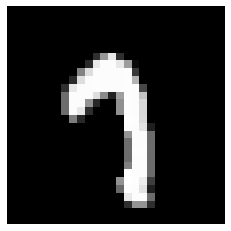

[143.41431149 168.28898897 171.5393248  204.51499223 226.47170461
 201.13664129 118.00435407 250.29439121 205.23317704 253.74276434]
Sample #5
Label: 5
Prediction: 3.0


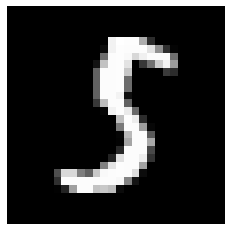

[189.34577539 184.91351475 192.14038432 230.70225499 124.25760308
 230.17149294 163.31858672  86.25436774 218.90599772 146.78395358]


In [24]:
# 10 random misclassified digits
import random

sample = random.sample(filter, 5)
for val in sample:
    print(f'Sample #{sample.index(val) + 1}')
    print(f'Label: {test_labels[val]}')
    print(f'Prediction: {pred[val]}')
    displaychar(test_data[val])
    print(probs[val])

A final showcase of what some of the errors in classification looked like; errors where the digits were different enough from the typical visual digit representations, to the point of resembling other digits. The best example of this phenomena, from the provided samples, is sample #2.